## Initialize

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the data
train_data = pd.read_csv("/kaggle/input/competitions/house-prices-advanced-regression-techniques/train.csv")

# Preview the data to make sure it loaded
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Baseline Model
Since this data is massive with 81 columns, doing the data cleaning would take more time than usual. I will first try to quickly etablish a baseline model based on numeric attributes. 

In [3]:
from sklearn.model_selection import train_test_split
# Select numeric features
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']

X = train_data[features]
y = train_data['SalePrice']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
# Train the model
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)

# Evaluate the model
val_predictions = model.predict(X_val)
val_mae = mean_absolute_error(y_val, val_predictions)

print(f"Mean Absolute Error (MAE): ${val_mae:,.0f}")

Mean Absolute Error (MAE): $22,256


Now I have the MAE is 22,256$ my goal is to reduce this MAE as low as possible

## Data Visualisation

First I will try to have a look at the shape of price distribution

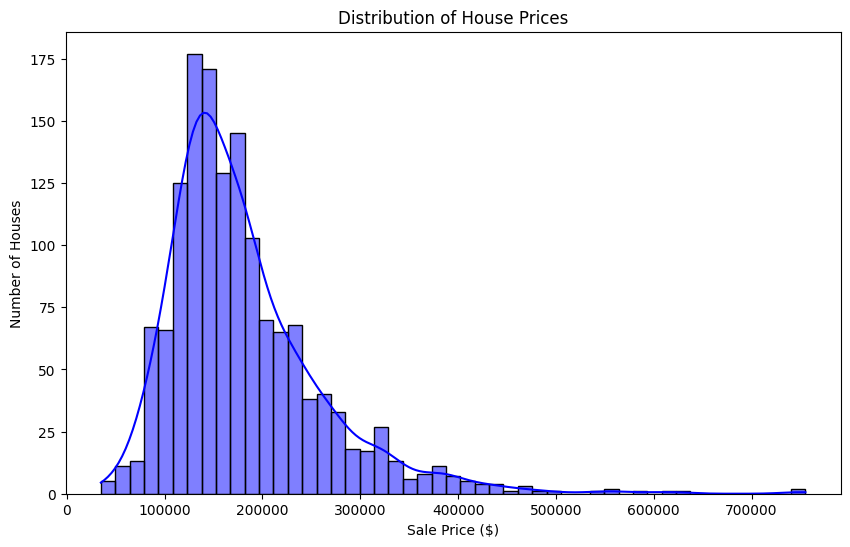

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], kde=True, color='blue')
plt.title('Distribution of House Prices')
plt.xlabel('Sale Price ($)')
plt.ylabel('Number of Houses')
plt.show()

I notice that most of the house's price is from 100,000 to 400,000 however there are a few houses with higher prices that skew the data, I will need to handle those outlier later.<br>
Next I will find the coorelation between **SalePrice** and **GrLivArea** (one of the most obvious features that affect the Sale Price)

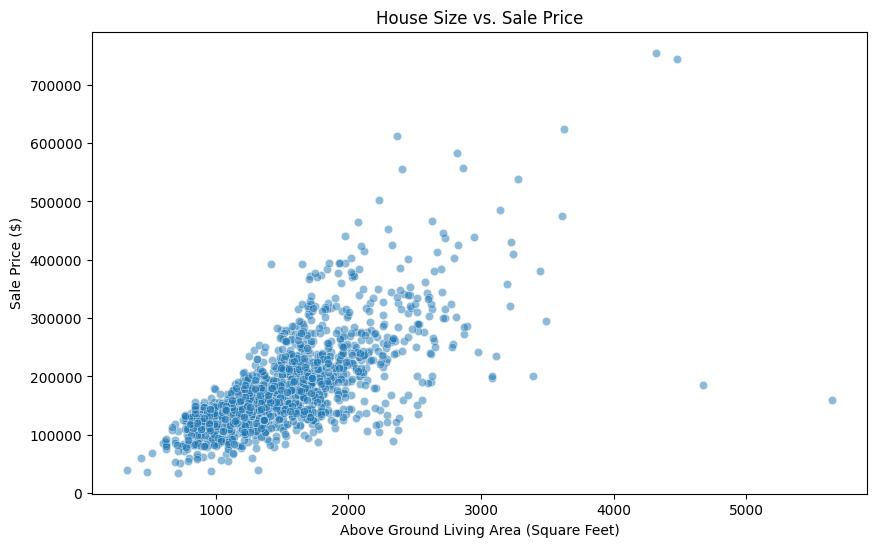

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_data['GrLivArea'], y=train_data['SalePrice'], alpha=0.5)
plt.title('House Size vs. Sale Price')
plt.xlabel('Above Ground Living Area (Square Feet)')
plt.ylabel('Sale Price ($)')
plt.show()

As the area goes up, the house price also goes up but there is some dot at the bottom right indicating that there are fews houses that have large area but is sold with small price. These data can affect my model training so I also need to remove these rows later.<br>
Since the data is composed of 81 columns and I cannot manually visualize all of them, I will need to use correlation matrix to see which features mostly affect the **SalePrice**

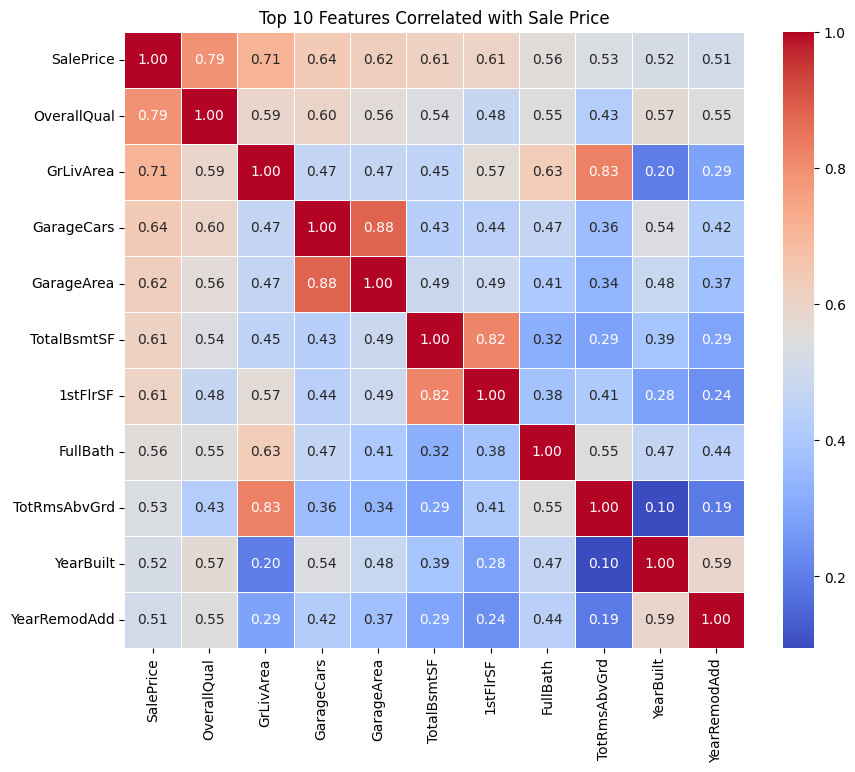

In [7]:
# 1. Calculate the correlation matrix 
# (numeric_only=True is crucial here so it ignores the text columns for now)
corr_matrix = train_data.corr(numeric_only=True)

# 2. Find the Top 10 features most correlated with SalePrice
top_features = corr_matrix.nlargest(11, 'SalePrice')['SalePrice'].index

# 3. Create a mini-matrix just for those top features
top_corr = train_data[top_features].corr()

# 4. Draw the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(top_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Top 10 Features Correlated with Sale Price")
plt.show()

From the matrix, it is showed that **OverallQual** (Overall Quality) also affect strongly the price. Other features such as **GarageCars**, **GarageArea**, **TotalBsmtSF**, **1stFlsSF**, etc also have effect on **SalePrice**. I also notice that some features have correlation with the other like **GarageCars** and **GarageArea** or **TotalBsmtSF** and **1stFlsSF** so I can drop one of them in the training

## Data Processing
Now that I've visualized the data the next step will be process the data. First, I will try to replace the null value

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

By comparing the information from the data description with this, some attribute that has missing values such as **Alley** **MasVnrType** **BsmtFinSF2** are indeed having value but that value is default to be null. Meanwhile the **Electrical** has 1 missing value so I will delete that row. The null value of **MasVnrArea** and **LotFrontage** will be filled by the median value. However I remarked that the **MasVnrArea** has a lot more value than **MasVnrType** so that means the value from **MasVnrArea** that **MasVnrType** is null is also 0 not the median value !!!

In [9]:
# 1. DROP THE MISSING ELECTRICAL ROW
train_data = train_data.dropna(subset=['Electrical'])

# 2. FILL LOT FRONTAGE WITH MEDIAN
lot_median = train_data['LotFrontage'].median()
train_data['LotFrontage'] = train_data['LotFrontage'].fillna(lot_median)

# 3. FIX THE MASONRY VENEER TRAP
train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(0)
train_data['MasVnrType'] = train_data['MasVnrType'].fillna("None")

# 4. FIX THE "NA MEANS NONE" COLUMNS
na_means_none_cols = [
    'Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'
]

for col in na_means_none_cols:
    train_data[col] = train_data[col].fillna("None")

In [10]:
train_data.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64